# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model
import cv2


/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/ten

# 1. 데이터 불러오기

In [2]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 320, 120, 1))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/Documents/final_lane_datas/final/*.npz')
#print(training_data)

for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        y = data['train_labels']
        temp=cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) # convert color to gray
        #print(x.shape,temp.shape)
    x = np.reshape(temp, ( -1, 320, 120, 1))
    
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))


print(x_train.shape)
# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
(2253, 320, 120, 1)
(1577, 320, 120, 1) (1577, 3)
(676, 320, 120, 1) (676, 3)


# 데이터 확인

In [3]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [4]:
#y_data.count()

In [5]:
#left = y_data.loc[y_data[:][0] == 1]

In [6]:
#left.count()

In [7]:
#right = y_data.loc[y_data[:][1] == 1]

In [8]:
#right.count()

In [9]:
#forward = y_data.loc[y_data[:][2] == 1]

In [10]:
#forward.count()

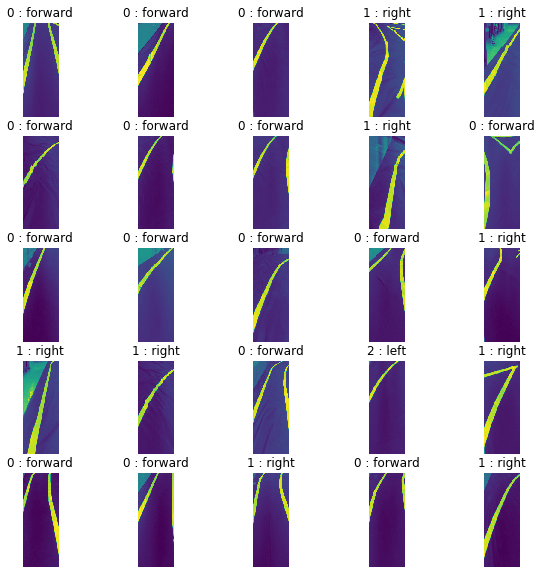

In [11]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(320, 120))
    
    label = np.argmax(y_train[i])
                      
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
#     elif label == 3:
#         direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [12]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 320
    W = 120
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [13]:
model = posla_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 118, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 318, 118, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 159, 59, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 157, 57, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 78, 28, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 26, 18)        1476      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 13, 18)        0         
__________

In [14]:
# from tensorflow.python.keras.utils import plot_model
# plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [15]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [18]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [19]:
EPOCHS = 100
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [20]:
from tensorflow.keras.utils import to_categorical


In [21]:
y_binary = to_categorical(y_train)

In [22]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 1261 samples, validate on 316 samples
Epoch 1/100
1261/1261 [==============================] - 5s 4ms/step - loss: 3.6954 - acc: 0.2609 - val_loss: 1.9017 - val_acc: 0.4462
Epoch 2/100
1261/1261 [==============================] - 1s 430us/step - loss: 2.5343 - acc: 0.3584 - val_loss: 0.9714 - val_acc: 0.5222
Epoch 3/100
1261/1261 [==============================] - 1s 411us/step - loss: 1.8818 - acc: 0.4600 - val_loss: 0.9051 - val_acc: 0.5190
Epoch 4/100
1261/1261 [==============================] - 1s 416us/step - loss: 1.6832 - acc: 0.4814 - val_loss: 0.8711 - val_acc: 0.5886
Epoch 5/100
1261/1261 [==============================] - 1s 402us/step - loss: 1.4534 - acc: 0.5028 - val_loss: 0.8633 - val_acc: 0.6108
Epoch 6/100
1261/1261 [==============================] - 1s 400us/step - loss: 1.4255 - acc: 0.5075 - val_loss: 0.8715 - val_acc: 0.6551
Epoch 7/100
1261/1261 [==============================] - 1s 423us/step - loss: 1.3004 - acc: 0.5496 - val_loss: 0.8805 - val_acc: 0.6

1261/1261 [==============================] - 1s 423us/step - loss: 0.8060 - acc: 0.6431 - val_loss: 0.7622 - val_acc: 0.6994
Epoch 61/100
1261/1261 [==============================] - 1s 412us/step - loss: 0.8265 - acc: 0.6416 - val_loss: 0.7607 - val_acc: 0.7057
Epoch 62/100
1261/1261 [==============================] - 1s 417us/step - loss: 0.8078 - acc: 0.6447 - val_loss: 0.7615 - val_acc: 0.7089
Epoch 63/100
1261/1261 [==============================] - 1s 408us/step - loss: 0.7937 - acc: 0.6764 - val_loss: 0.7606 - val_acc: 0.7025
Epoch 64/100
1261/1261 [==============================] - 1s 422us/step - loss: 0.7997 - acc: 0.6646 - val_loss: 0.7581 - val_acc: 0.6994
Epoch 65/100
1261/1261 [==============================] - 1s 415us/step - loss: 0.8038 - acc: 0.6622 - val_loss: 0.7558 - val_acc: 0.6962
Epoch 66/100
1261/1261 [==============================] - 1s 403us/step - loss: 0.7979 - acc: 0.6598 - val_loss: 0.7541 - val_acc: 0.7025
Epoch 67/100
1261/1261 [=======================

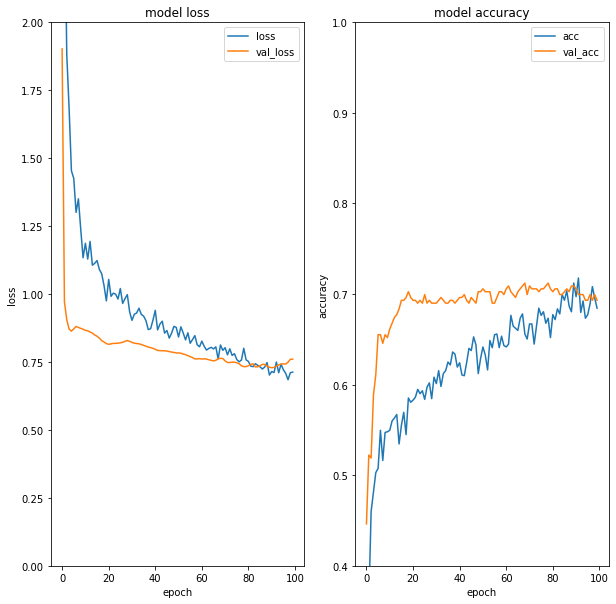

In [23]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [24]:
#l_model = load_model('./model_data/VGG_model.h5')

In [25]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

676/676 [==============================] - 0s 424us/step
## evaluation loss and_metrics ##
[0.7519984128912525, 0.7573964542891147]


In [26]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 1, Predict : 1
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 0
True : 0, Predict : 0


# 7. 최종 모델 훈련

In [27]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(2253, 320, 120, 1)
(2253, 3)


In [28]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [30]:
EPOCHS = 1000
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [31]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Epoch 1/1000
2253/2253 [==============================] - 2s 966us/step - loss: 0.7889 - acc: 0.6915
Epoch 2/1000
2253/2253 [==============================] - 1s 353us/step - loss: 0.7634 - acc: 0.6844
Epoch 3/1000
2253/2253 [==============================] - 1s 374us/step - loss: 0.7849 - acc: 0.6835
Epoch 4/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.7603 - acc: 0.6795
Epoch 5/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.7646 - acc: 0.6982
Epoch 6/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.7418 - acc: 0.6880
Epoch 7/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.7662 - acc: 0.6871
Epoch 8/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.7224 - acc: 0.6968
Epoch 9/1000
2253/2253 [==============================] - 1s 362us/step - loss: 0.7635 - acc: 0.6742
Epoch 10/1000
2253/2253 [==============================] - 1s 365us/step - loss: 0.7296 - a

2253/2253 [==============================] - 1s 368us/step - loss: 0.5332 - acc: 0.7705
Epoch 82/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.5476 - acc: 0.7679
Epoch 83/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.5462 - acc: 0.7688
Epoch 84/1000
2253/2253 [==============================] - 1s 362us/step - loss: 0.5300 - acc: 0.7688
Epoch 85/1000
2253/2253 [==============================] - 1s 380us/step - loss: 0.5345 - acc: 0.7754
Epoch 86/1000
2253/2253 [==============================] - 1s 370us/step - loss: 0.5321 - acc: 0.7812
Epoch 87/1000
2253/2253 [==============================] - 1s 365us/step - loss: 0.5191 - acc: 0.7834
Epoch 88/1000
2253/2253 [==============================] - 1s 364us/step - loss: 0.5243 - acc: 0.7741
Epoch 89/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.5049 - acc: 0.7852
Epoch 90/1000
2253/2253 [==============================] - 1s 372us/step - loss: 0.5381 - acc: 0

2253/2253 [==============================] - 1s 367us/step - loss: 0.3894 - acc: 0.8358
Epoch 161/1000
2253/2253 [==============================] - 1s 366us/step - loss: 0.3861 - acc: 0.8371
Epoch 162/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.3782 - acc: 0.8447
Epoch 163/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.3867 - acc: 0.8349
Epoch 164/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.4006 - acc: 0.8331
Epoch 165/1000
2253/2253 [==============================] - 1s 378us/step - loss: 0.3855 - acc: 0.8402
Epoch 166/1000
2253/2253 [==============================] - 1s 362us/step - loss: 0.3983 - acc: 0.8336
Epoch 167/1000
2253/2253 [==============================] - 1s 378us/step - loss: 0.3867 - acc: 0.8358
Epoch 168/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.3947 - acc: 0.8358
Epoch 169/1000
2253/2253 [==============================] - 1s 370us/step - loss: 0.4074

2253/2253 [==============================] - 1s 371us/step - loss: 0.2959 - acc: 0.8731
Epoch 240/1000
2253/2253 [==============================] - 1s 378us/step - loss: 0.2836 - acc: 0.8828
Epoch 241/1000
2253/2253 [==============================] - 1s 364us/step - loss: 0.2902 - acc: 0.8775
Epoch 242/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.2824 - acc: 0.8877
Epoch 243/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.2921 - acc: 0.8819
Epoch 244/1000
2253/2253 [==============================] - 1s 365us/step - loss: 0.2906 - acc: 0.8771
Epoch 245/1000
2253/2253 [==============================] - 1s 380us/step - loss: 0.3036 - acc: 0.8731
Epoch 246/1000
2253/2253 [==============================] - 1s 355us/step - loss: 0.3018 - acc: 0.8753
Epoch 247/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.3000 - acc: 0.8806
Epoch 248/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.2992

2253/2253 [==============================] - 1s 370us/step - loss: 0.2194 - acc: 0.9099
Epoch 319/1000
2253/2253 [==============================] - 1s 379us/step - loss: 0.2336 - acc: 0.8948
Epoch 320/1000
2253/2253 [==============================] - 1s 362us/step - loss: 0.2370 - acc: 0.8992
Epoch 321/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.2314 - acc: 0.9024
Epoch 322/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.2256 - acc: 0.9037
Epoch 323/1000
2253/2253 [==============================] - 1s 372us/step - loss: 0.2308 - acc: 0.9019
Epoch 324/1000
2253/2253 [==============================] - 1s 365us/step - loss: 0.2336 - acc: 0.8984
Epoch 325/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.2265 - acc: 0.9028
Epoch 326/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.2191 - acc: 0.9112
Epoch 327/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.2301

2253/2253 [==============================] - 1s 374us/step - loss: 0.1913 - acc: 0.9170
Epoch 398/1000
2253/2253 [==============================] - 1s 374us/step - loss: 0.1851 - acc: 0.9166
Epoch 399/1000
2253/2253 [==============================] - 1s 359us/step - loss: 0.1973 - acc: 0.9206
Epoch 400/1000
2253/2253 [==============================] - 1s 381us/step - loss: 0.1852 - acc: 0.9183
Epoch 401/1000
2253/2253 [==============================] - 1s 364us/step - loss: 0.1889 - acc: 0.9188
Epoch 402/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.1809 - acc: 0.9241
Epoch 403/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.1841 - acc: 0.9245
Epoch 404/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.1764 - acc: 0.9303
Epoch 405/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.1903 - acc: 0.9183
Epoch 406/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.1831

2253/2253 [==============================] - 1s 364us/step - loss: 0.1643 - acc: 0.9268
Epoch 477/1000
2253/2253 [==============================] - 1s 366us/step - loss: 0.1623 - acc: 0.9263
Epoch 478/1000
2253/2253 [==============================] - 1s 370us/step - loss: 0.1560 - acc: 0.9299
Epoch 479/1000
2253/2253 [==============================] - 1s 353us/step - loss: 0.1553 - acc: 0.9299
Epoch 480/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.1505 - acc: 0.9348
Epoch 481/1000
2253/2253 [==============================] - 1s 355us/step - loss: 0.1691 - acc: 0.9228
Epoch 482/1000
2253/2253 [==============================] - 1s 361us/step - loss: 0.1492 - acc: 0.9356
Epoch 483/1000
2253/2253 [==============================] - 1s 374us/step - loss: 0.1554 - acc: 0.9361
Epoch 484/1000
2253/2253 [==============================] - 1s 374us/step - loss: 0.1613 - acc: 0.9303
Epoch 485/1000
2253/2253 [==============================] - 1s 374us/step - loss: 0.1613

2253/2253 [==============================] - 1s 367us/step - loss: 0.1375 - acc: 0.9383
Epoch 556/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.1286 - acc: 0.9427
Epoch 557/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.1376 - acc: 0.9392
Epoch 558/1000
2253/2253 [==============================] - 1s 365us/step - loss: 0.1275 - acc: 0.9490
Epoch 559/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.1335 - acc: 0.9432
Epoch 560/1000
2253/2253 [==============================] - 1s 374us/step - loss: 0.1309 - acc: 0.9436
Epoch 561/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.1501 - acc: 0.9343
Epoch 562/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.1427 - acc: 0.9387
Epoch 563/1000
2253/2253 [==============================] - 1s 361us/step - loss: 0.1330 - acc: 0.9436
Epoch 564/1000
2253/2253 [==============================] - 1s 369us/step - loss: 0.1470

2253/2253 [==============================] - 1s 370us/step - loss: 0.1322 - acc: 0.9401
Epoch 635/1000
2253/2253 [==============================] - 1s 359us/step - loss: 0.1276 - acc: 0.9410
Epoch 636/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.1244 - acc: 0.9396
Epoch 637/1000
2253/2253 [==============================] - 1s 370us/step - loss: 0.1160 - acc: 0.9503
Epoch 638/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.1161 - acc: 0.9476
Epoch 639/1000
2253/2253 [==============================] - 1s 367us/step - loss: 0.1252 - acc: 0.9427
Epoch 640/1000
2253/2253 [==============================] - 1s 367us/step - loss: 0.1246 - acc: 0.9463
Epoch 641/1000
2253/2253 [==============================] - 1s 367us/step - loss: 0.1292 - acc: 0.9419
Epoch 642/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.1184 - acc: 0.9436
Epoch 643/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.1241

2253/2253 [==============================] - 1s 370us/step - loss: 0.1178 - acc: 0.9481
Epoch 714/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.1116 - acc: 0.9485
Epoch 715/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.1076 - acc: 0.9507
Epoch 716/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.1118 - acc: 0.9467
Epoch 717/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.1095 - acc: 0.9481
Epoch 718/1000
2253/2253 [==============================] - 1s 386us/step - loss: 0.1101 - acc: 0.9494
Epoch 719/1000
2253/2253 [==============================] - 1s 366us/step - loss: 0.1020 - acc: 0.9534
Epoch 720/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.1097 - acc: 0.9494
Epoch 721/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.1037 - acc: 0.9494
Epoch 722/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.1121

2253/2253 [==============================] - 1s 352us/step - loss: 0.1021 - acc: 0.9467
Epoch 793/1000
2253/2253 [==============================] - 1s 367us/step - loss: 0.0965 - acc: 0.9565
Epoch 794/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.0993 - acc: 0.9525
Epoch 795/1000
2253/2253 [==============================] - 1s 368us/step - loss: 0.0973 - acc: 0.9552
Epoch 796/1000
2253/2253 [==============================] - 1s 366us/step - loss: 0.1031 - acc: 0.9516
Epoch 797/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.1038 - acc: 0.9521
Epoch 798/1000
2253/2253 [==============================] - 1s 366us/step - loss: 0.1120 - acc: 0.9481
Epoch 799/1000
2253/2253 [==============================] - 1s 379us/step - loss: 0.1013 - acc: 0.9538
Epoch 800/1000
2253/2253 [==============================] - 1s 382us/step - loss: 0.0936 - acc: 0.9565
Epoch 801/1000
2253/2253 [==============================] - 1s 362us/step - loss: 0.1012

2253/2253 [==============================] - 1s 370us/step - loss: 0.0967 - acc: 0.9556
Epoch 872/1000
2253/2253 [==============================] - 1s 376us/step - loss: 0.0921 - acc: 0.9587
Epoch 873/1000
2253/2253 [==============================] - 1s 377us/step - loss: 0.0913 - acc: 0.9547
Epoch 874/1000
2253/2253 [==============================] - 1s 370us/step - loss: 0.0879 - acc: 0.9605
Epoch 875/1000
2253/2253 [==============================] - 1s 375us/step - loss: 0.1025 - acc: 0.9543
Epoch 876/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.0982 - acc: 0.9530
Epoch 877/1000
2253/2253 [==============================] - 1s 360us/step - loss: 0.0973 - acc: 0.9530
Epoch 878/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.0963 - acc: 0.9547
Epoch 879/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.1054 - acc: 0.9490
Epoch 880/1000
2253/2253 [==============================] - 1s 366us/step - loss: 0.0998

2253/2253 [==============================] - 1s 362us/step - loss: 0.0915 - acc: 0.9543
Epoch 951/1000
2253/2253 [==============================] - 1s 373us/step - loss: 0.0865 - acc: 0.9601
Epoch 952/1000
2253/2253 [==============================] - 1s 370us/step - loss: 0.0928 - acc: 0.9534
Epoch 953/1000
2253/2253 [==============================] - 1s 371us/step - loss: 0.0902 - acc: 0.9601
Epoch 954/1000
2253/2253 [==============================] - 1s 363us/step - loss: 0.0886 - acc: 0.9561
Epoch 955/1000
2253/2253 [==============================] - 1s 358us/step - loss: 0.0869 - acc: 0.9618
Epoch 956/1000
2253/2253 [==============================] - 1s 372us/step - loss: 0.0880 - acc: 0.9627
Epoch 957/1000
2253/2253 [==============================] - 1s 364us/step - loss: 0.0821 - acc: 0.9640
Epoch 958/1000
2253/2253 [==============================] - 1s 378us/step - loss: 0.0956 - acc: 0.9578
Epoch 959/1000
2253/2253 [==============================] - 1s 381us/step - loss: 0.0930

In [32]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

676/676 [==============================] - 0s 453us/step
## evaluation loss and_metrics ##
[0.01167120845139732, 0.9985207100591716]


In [33]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0


# 8. 모델 저장

In [35]:
#model.save('./model_data/video_model_3.h5')

In [34]:
from tensorflow.python.keras.models import model_from_yaml

model_yaml = model.to_yaml()
with open("lane_model_v3-02.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("lane_model_v3-02.h5")
print("Saved model to disk")

Saved model to disk
